# MEGI001-2101033 Introduction to Earth System Data

## Task 6.4 - Data Handling Analysis (2-D)

Created on: Jan 25, 2019 by Ralph Florent <r.florent@jacobs-university.de>

## T6.4

please try to use any other thin section from ```data_samples``` or the links above and experience with the code above. Please report on challenges and difficulties, indicating what might be the cause.

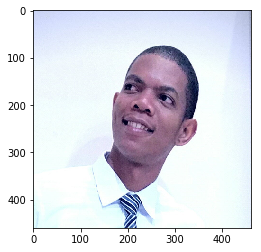

In [2]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

url= "https://avatars0.githubusercontent.com/u/24193665?v=4"
from io import BytesIO
response = requests.get(url)
img = np.asarray(Image.open(BytesIO(response.content)))
plt.imshow(img) 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


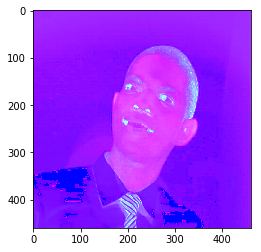

In [3]:
#convert from rgb to hsv
imgHSV=mpl.colors.rgb_to_hsv(img)
plt.imshow(imgHSV)
plt.show()

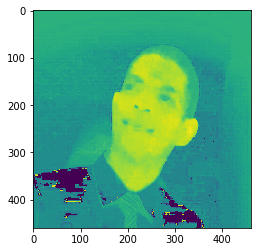

In [4]:
#extract hue
# see https://github.com/scivision/pyimagevideo/blob/master/RGB_BGR_GBR_conv.py
imgHue=imgHSV[:,:,0]
plt.imshow(imgHue)
plt.show()

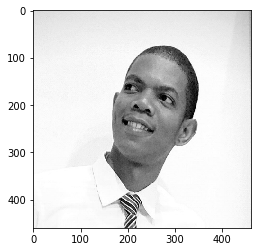

In [5]:
imgF=img.astype('float') # we will perform floating point arithmetic, so we must convert data to appropriate type
imgGray=(imgF[:,:,0]+imgF[:,:,1]+imgF[:,:,2])/3.
plt.imshow(imgGray, cmap='gray')
plt.show()

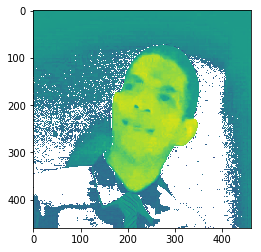

In [6]:
#we can use grayscale image as a mask
imgHueMasked=np.ma.masked_array(data = imgHue,
             mask = imgGray>250,
       fill_value = 999999)
plt.imshow(imgHueMasked)
plt.show()

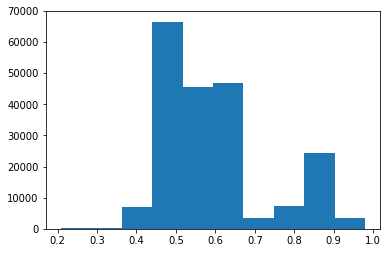

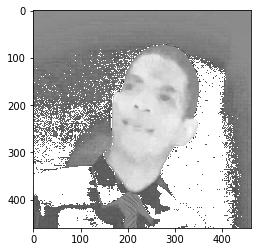

In [7]:
#Lets take a look at a histogram
mpl.pyplot.hist(imgHueMasked.flatten(), bins=10)
plt.show()
plt.imshow(imgHueMasked, cmap='gray')
plt.show()

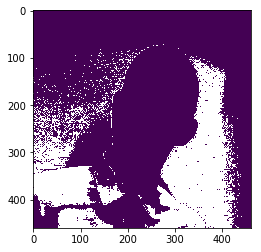

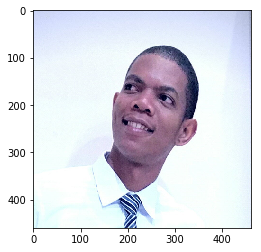

In [8]:
#Looks like all the oolites appear black on this image
#we can now separate the grains from the matrix by applying a threshold:
imgThresh=imgHueMasked<0.2 # if oolite -> 1, if matrix -> 0
plt.imshow(imgThresh)
plt.show()
plt.imshow(img) 
plt.show()

# See also:
# https://github.com/piratefsh/image-processing-101/blob/master/Image%20Processing%20101.ipynb

In [9]:
#Now we can compute the % of matrix/cement.
print('There are %s pixels in this image' % imgThresh.count())
#inline string substitution, the result is the same as in
#print('There are ', imgThresh.count(), ' pixels in this image')
print('of which %s are oolites.' %imgThresh.sum())
percentMatrix=((1-imgThresh.sum()/imgThresh.count())*100)
print('Which means %.2f%% matrix (or cement).' %percentMatrix)

There are 153531 pixels in this image
of which 0 are oolites.
Which means 100.00% matrix (or cement).


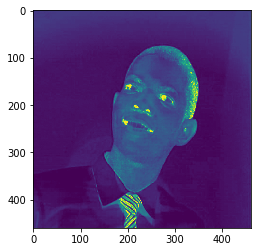

In [10]:
from scipy.ndimage import morphology
from skimage import morphology as mrph#, thin

import scipy

# We can first try to extract the grain boundary, and see if we get polyg
sat=imgHSV[:,:,1]
plt.imshow(sat)
plt.show()

In [11]:
# filtering

sobelH=np.asarray([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
sobelV=np.asarray([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

C:\Users\ralflorent\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


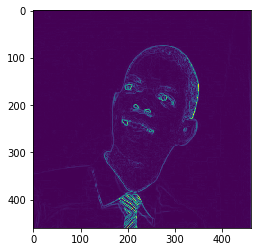

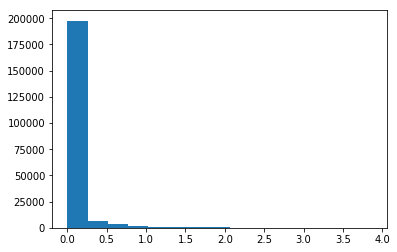

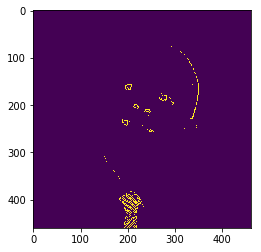

In [12]:
satConvH=scipy.ndimage.filters.convolve(sat,sobelH, mode='constant')
satConvV=scipy.ndimage.filters.convolve(sat,sobelV, mode='constant')
satEdge=np.sqrt(satConvH**2+satConvV**2)
plt.imshow(satEdge)
plt.show()
mpl.pyplot.hist(satEdge.flatten(), bins=15)
plt.show()
plt.imshow(satEdge>1.5)
plt.show()

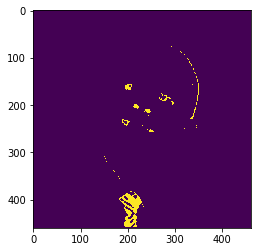

In [14]:
# Define functions to do morphologic operations on binary arrays
imClose = lambda img, itr, rad: morphology.binary_closing(img, iterations=itr, structure=mrph.disk(radius=rad))
imOpen  = lambda img, itr, rad: morphology.binary_opening(img, iterations=itr, structure=mrph.disk(radius=rad))
plt.imshow(imClose(satEdge>1.5,1,2))
plt.show()

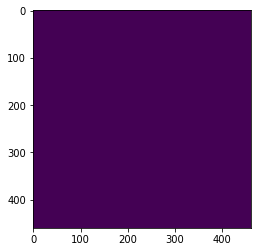

In [15]:
imgToErode=imgThresh.data*(1-imgThresh.mask)
imgThreshCosing=imClose(imgToErode,3,2)
plt.imshow(imgThreshCosing)
plt.show()

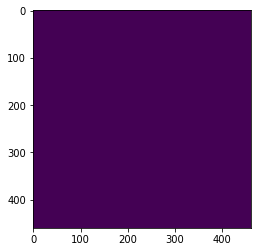

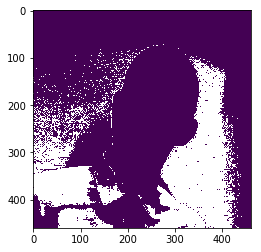

In [16]:
imgThreshCOpen=imOpen(imgThreshCosing,3,5)
plt.imshow(imgThreshCOpen)
plt.show()
plt.imshow(imgThresh) 
plt.show()

In [17]:
#from here on we can use segmentation by random walker
# https://www.scipy-lectures.org/packages/scikit-image/auto_examples/plot_segmentations.html
toSegment=imgThreshCOpen

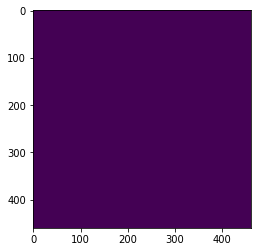

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage

distance = ndimage.distance_transform_edt(toSegment)
#smooth it with convolution
distance=scipy.ndimage.filters.convolve(distance.astype('float'),np.ones((3,3)).astype('float')/9, mode='constant')
plt.imshow(distance)
plt.show()
distance

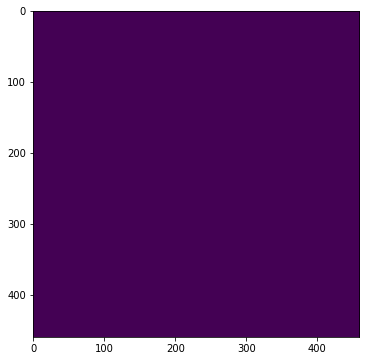

In [19]:
plt.figure(figsize=(6,6))
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)))#, labels=toSegment)
plt.imshow(local_maxi)
plt.show()

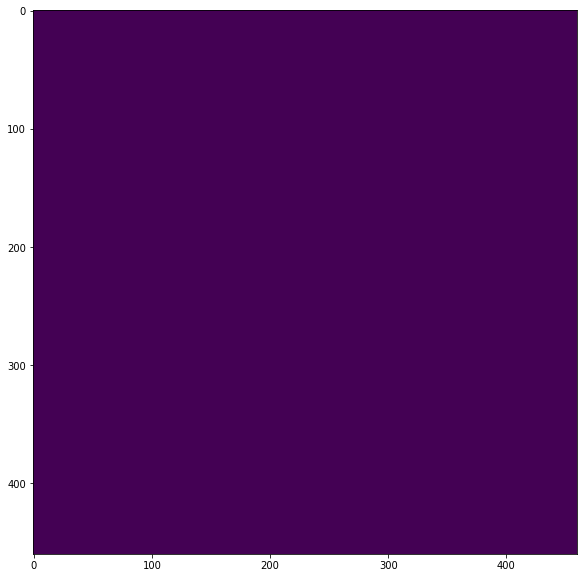

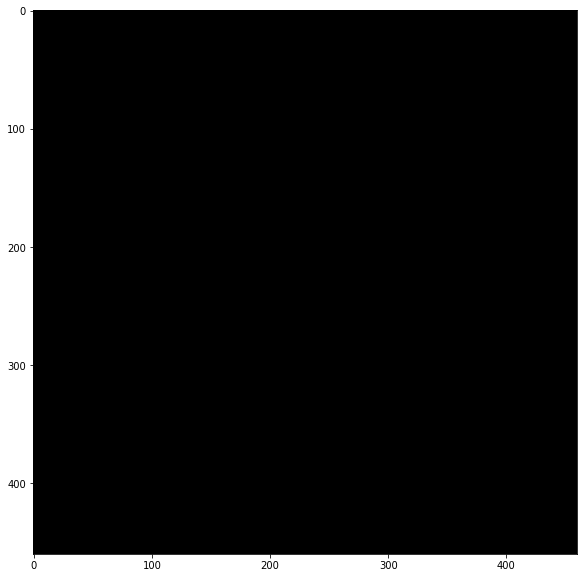

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


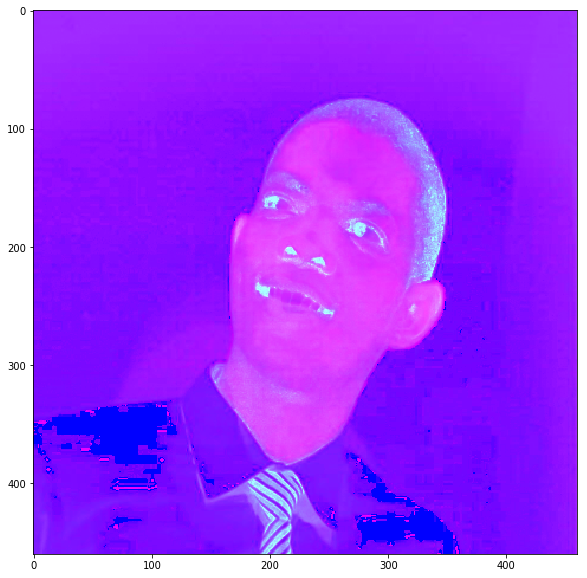

In [20]:
plt.figure(figsize=(10,10))
markers = measure.label(local_maxi)
plt.imshow(markers)
plt.show()
plt.figure(figsize=(10,10))
labels_ws = watershed(-distance, markers, mask=toSegment)
#plt.imshow(labels_ws)
plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(imgHSV)
plt.show()

In [21]:
#we can find all the unique values on a segmented image
np.unique(labels_ws)

array([0])

C:\Users\ralflorent\Anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\ralflorent\Anaconda3\lib\site-packages\matplotlib\image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\ralflorent\Anaconda3\lib\site-packages\matplotlib\image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\ralflorent\Anaconda3\lib\site-packages\matplotlib\image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\ralflorent\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\ralflorent\Anaconda3\lib\site-packages\numpy\ma\core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


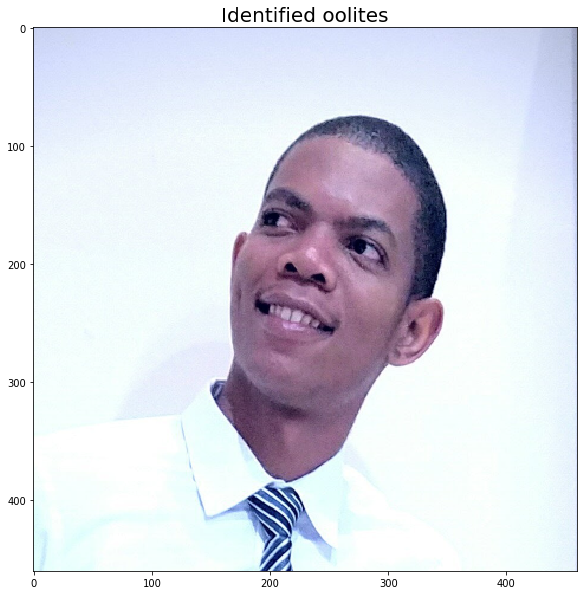

There is approximately 0 oolites on this image


In [22]:
#and count them:
plt.figure(figsize=(10,10))
plt.imshow(img) 
labels_ws_ma=np.ma.masked_array(labels_ws,1-imgThreshCOpen)
plt.imshow(labels_ws_ma, cmap='nipy_spectral', interpolation='nearest', alpha=0.5)
plt.title('Identified oolites', fontsize=20)
plt.show()
print('There is approximately %s oolites on this image' % str(len(np.unique(labels_ws))-1))

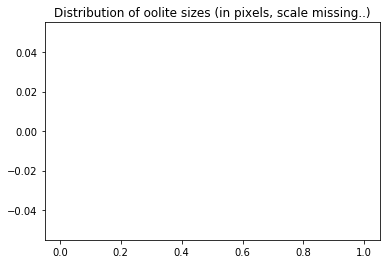

In [23]:
relativeSizes=[(labels_ws==i).sum() for i in np.unique(labels_ws)[1:]]
mpl.pyplot.hist(relativeSizes, bins=20)
plt.title('Distribution of oolite sizes (in pixels, scale missing..)')
plt.show()